In [14]:
import os
import re
import time
import json
import pickle
import signal
import logging
from datetime import datetime
from typing import Optional, Dict, Any, Tuple, Set, List
import PyPDF2
import itertools
import collections

# Third-Party Library
from fuzzywuzzy import process, fuzz
import requests
from urllib3.util.retry import Retry
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport


df = pd. read_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\final_data.csv")
print("\nData types:")
print(df.dtypes)



Data types:
final_title                   object
final_budget                 float64
final_worldwide_boxoffice    float64
final_domestic_boxoffice     float64
final_clean_title             object
                              ...   
is_Summer                      int64
is_Awards                      int64
is_Spring                      int64
is_Fall                        int64
title_year                    object
Length: 62, dtype: object


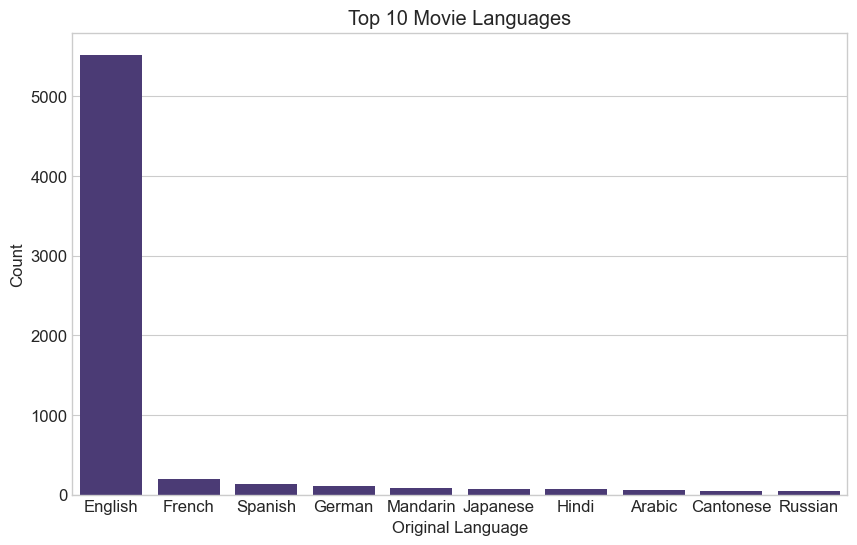

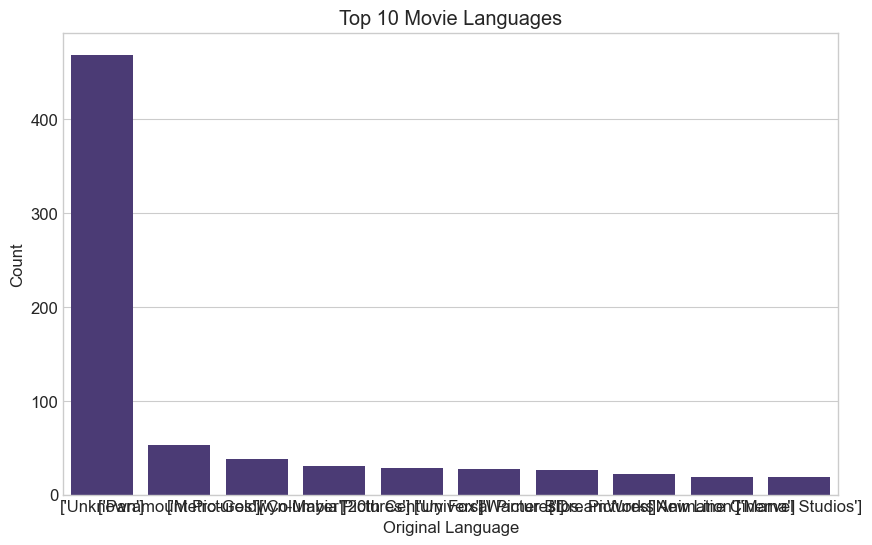

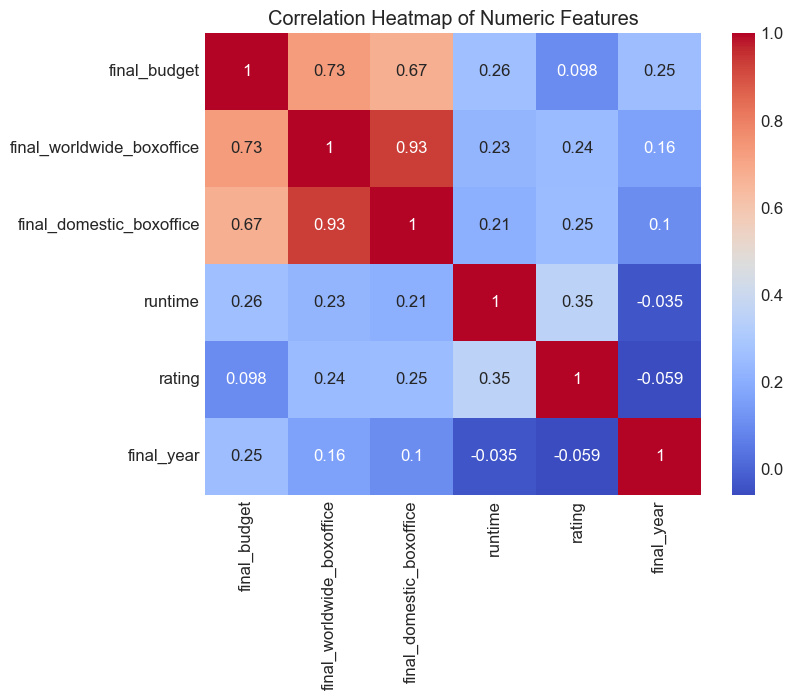

In [15]:
plt.figure(figsize=(10, 6))
lang_counts = df['original_language'].value_counts().head(10)
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title("Top 10 Movie Languages")
plt.xlabel("Original Language")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
lang_counts = df['production_companies_list'].value_counts().head(10)
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title("Top 10 Movie Languages")
plt.xlabel("Original Language")
plt.ylabel("Count")
plt.show()

numeric_cols = ['final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice', 'runtime', 'rating', 'final_year']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

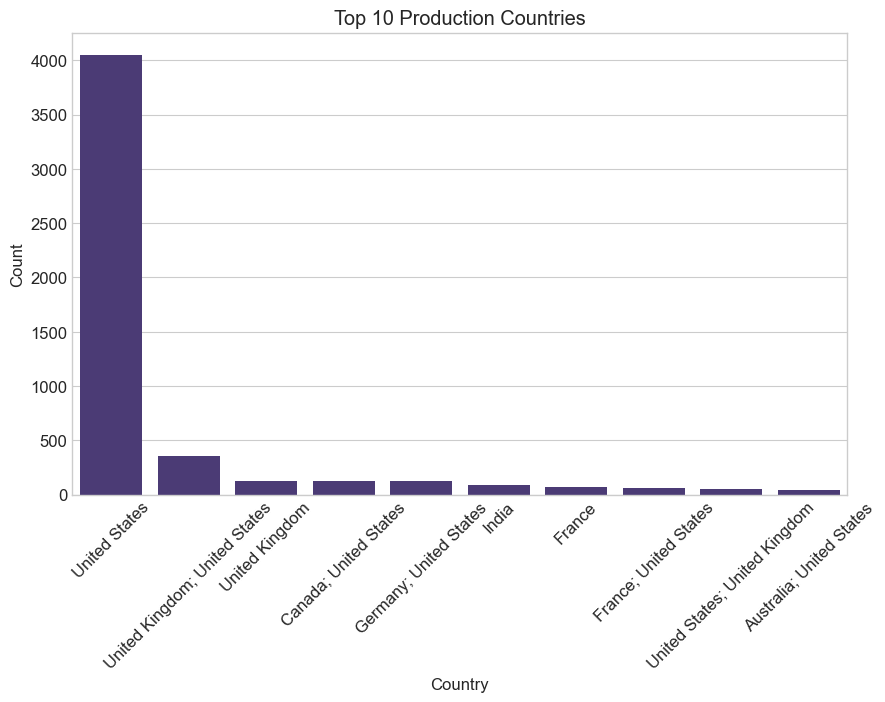

In [16]:
countries = df['production_countries_clean'].dropna().apply(lambda x: x.split(","))
countries_list = list(itertools.chain.from_iterable(countries))
countries_list = [c.strip() for c in countries_list]
country_counts = collections.Counter(countries_list)
top_countries = pd.DataFrame.from_dict(country_counts, orient="index", columns=["Count"]).sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries["Count"])
plt.title("Top 10 Production Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.ticker import FuncFormatter

# Set style parameters
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Read the dataset
df = pd.read_csv('final_data.csv')

# Initial data cleaning and preparation
# Handle any missing values
df = df.fillna({'final_budget': df['final_budget'].median(), 
                'final_worldwide_boxoffice': df['final_worldwide_boxoffice'].median(),
                'final_domestic_boxoffice': df['final_domestic_boxoffice'].median(),
                'director': 'Unknown',
                'star': 'Unknown',
                'production_companies': 'Unknown'})

# Format monetary values for better display
def format_money(x, pos):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.1f}M'
    else:
        return f'${x/1e3:.1f}K'

money_formatter = FuncFormatter(format_money)

# Create visualizations
visualizations = {}

C:\Users\divya\AppData\Local\Temp\ipykernel_28972\3790014554.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_roi.loc[top_genres][('roi', 'mean')].values,


<Figure size 1400x1000 with 0 Axes>

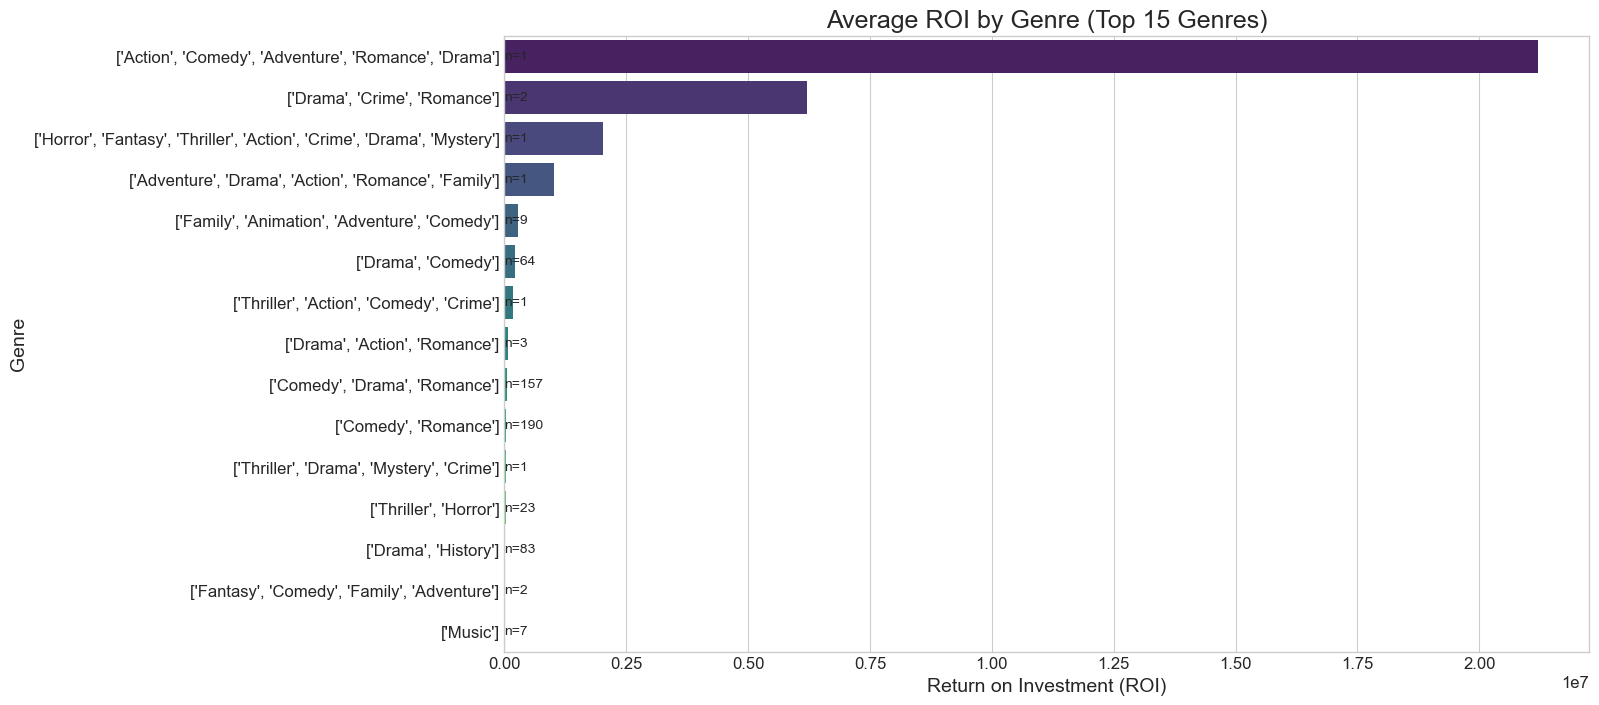

In [18]:
plt.figure(figsize=(14, 10))
genre_roi = df.groupby('genres_list').agg({'roi': ['mean', 'median', 'count']})
genre_roi = genre_roi.sort_values(('roi', 'mean'), ascending=False)
top_genres = genre_roi.head(15).index

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=genre_roi.loc[top_genres][('roi', 'mean')].values, 
                 y=top_genres, 
                 palette='viridis')
plt.title('Average ROI by Genre (Top 15 Genres)', fontsize=18)
plt.xlabel('Return on Investment (ROI)', fontsize=14)
plt.ylabel('Genre', fontsize=14)

for i, v in enumerate(genre_roi.loc[top_genres][('roi', 'count')].values):
    ax.text(0.5, i, f"n={v}", va='center', fontsize=10)

visualizations['roi_by_genre'] = plt

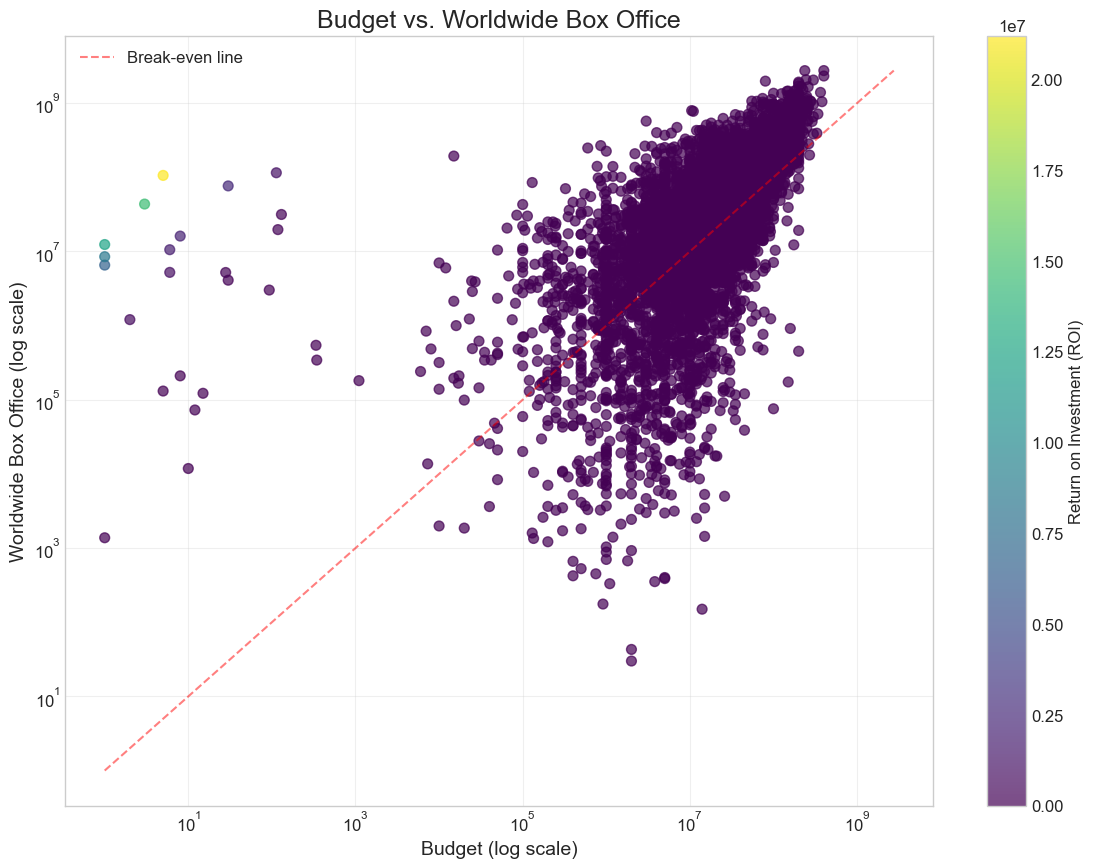

In [19]:
plt.figure(figsize=(14, 10))
plt.scatter(df['final_budget'], df['final_worldwide_boxoffice'], 
            c=df['roi'], cmap='viridis', alpha=0.7, s=50)
plt.colorbar(label='Return on Investment (ROI)')
plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs. Worldwide Box Office', fontsize=18)
plt.xlabel('Budget (log scale)', fontsize=14)
plt.ylabel('Worldwide Box Office (log scale)', fontsize=14)
plt.grid(True, alpha=0.3)

max_val = max(df['final_budget'].max(), df['final_worldwide_boxoffice'].max())
min_val = min(df['final_budget'].min(), df['final_worldwide_boxoffice'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Break-even line')
plt.legend()

visualizations['budget_vs_boxoffice'] = plt

<Figure size 1200x800 with 0 Axes>

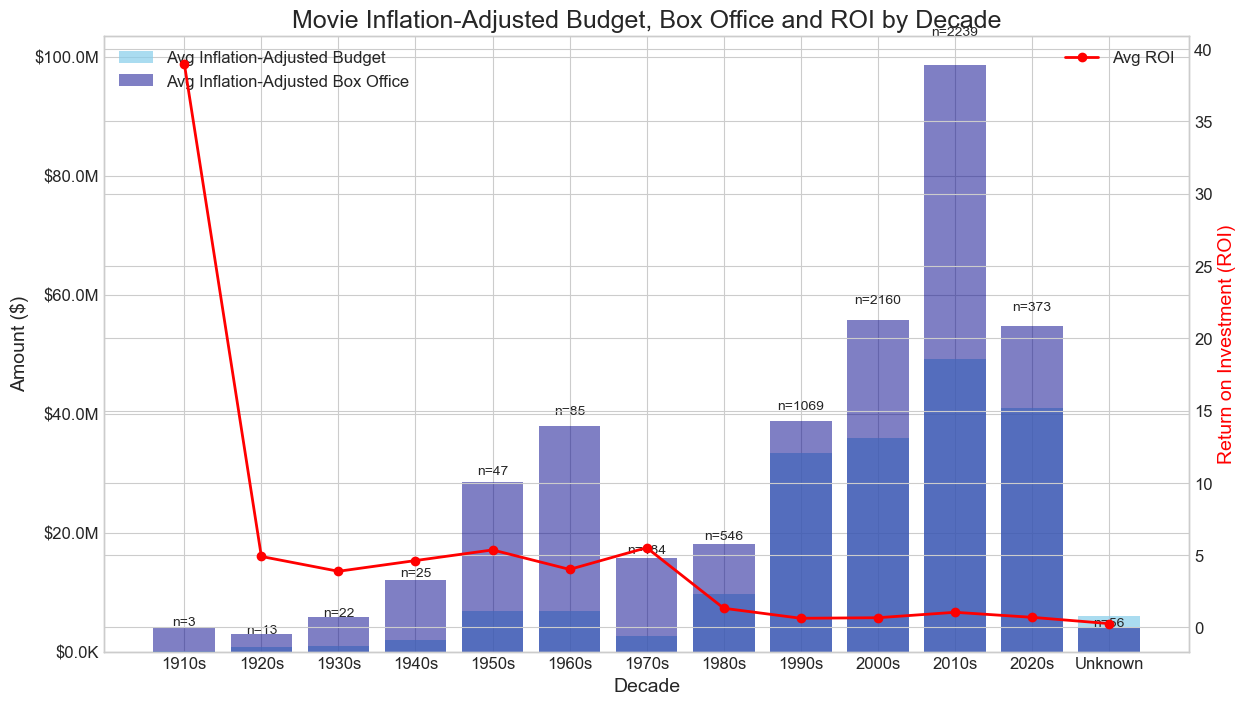

In [20]:
plt.figure(figsize=(12, 8))
decade_success = df.groupby('decade').agg({
    'inflation_adjusted_budget': 'median',
    'inflation_adjusted_worldwide_boxoffice': 'median',
    'roi': 'median',
    'final_title': 'count'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

ax1.bar(decade_success['decade'], decade_success['inflation_adjusted_budget'], 
        color='skyblue', alpha=0.7, label='Avg Inflation-Adjusted Budget')
ax1.bar(decade_success['decade'], decade_success['inflation_adjusted_worldwide_boxoffice'], 
        color='darkblue', alpha=0.5, label='Avg Inflation-Adjusted Box Office')
ax2.plot(decade_success['decade'], decade_success['roi'], 
         'ro-', linewidth=2, label='Avg ROI')

ax1.set_xlabel('Decade', fontsize=14)
ax1.set_ylabel('Amount ($)', fontsize=14)
ax2.set_ylabel('Return on Investment (ROI)', fontsize=14, color='r')
ax1.yaxis.set_major_formatter(money_formatter)
plt.title('Movie Inflation-Adjusted Budget, Box Office and ROI by Decade', fontsize=18)

# Add movie count annotations
for i, (decade, count) in enumerate(zip(decade_success['decade'], decade_success['final_title'])):
    ax1.text(i, decade_success['inflation_adjusted_worldwide_boxoffice'].iloc[i] * 1.05, 
             f"n={count}", ha='center', fontsize=10)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

visualizations['decade_success'] = plt


<Figure size 1400x800 with 0 Axes>

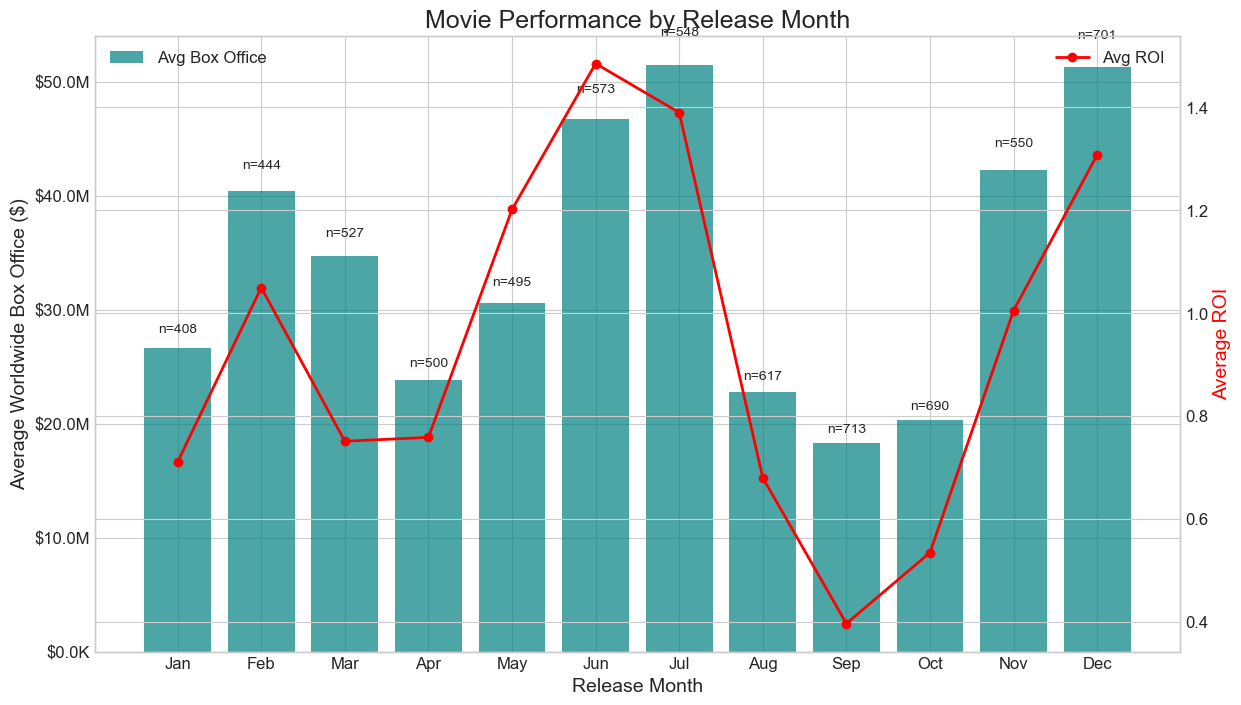

In [21]:
plt.figure(figsize=(14, 8))
season_perf = df.groupby(['release_month']).agg({
    'final_worldwide_boxoffice': 'median',
    'roi': 'median',
    'final_title': 'count'
}).reset_index()

# For better visualization, map month numbers to names
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
season_perf['month_name'] = season_perf['release_month'].map(month_names)
season_perf = season_perf.sort_values('release_month')

fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

ax1.bar(season_perf['month_name'], season_perf['final_worldwide_boxoffice'], 
        color='teal', alpha=0.7, label='Avg Box Office')
ax2.plot(season_perf['month_name'], season_perf['roi'], 
         'ro-', linewidth=2, label='Avg ROI')

ax1.set_xlabel('Release Month', fontsize=14)
ax1.set_ylabel('Average Worldwide Box Office ($)', fontsize=14)
ax2.set_ylabel('Average ROI', fontsize=14, color='r')
ax1.yaxis.set_major_formatter(money_formatter)
plt.title('Movie Performance by Release Month', fontsize=18)

# Add movie count annotations
for i, (month, count) in enumerate(zip(season_perf['month_name'], season_perf['final_title'])):
    ax1.text(i, season_perf['final_worldwide_boxoffice'].iloc[i] * 1.05, 
             f"n={count}", ha='center', fontsize=10)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

visualizations['seasonal_performance'] = plt

C:\Users\divya\AppData\Local\Temp\ipykernel_28972\630925011.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_perf = df.groupby('runtime_category_detail').agg({


<Figure size 1400x800 with 0 Axes>

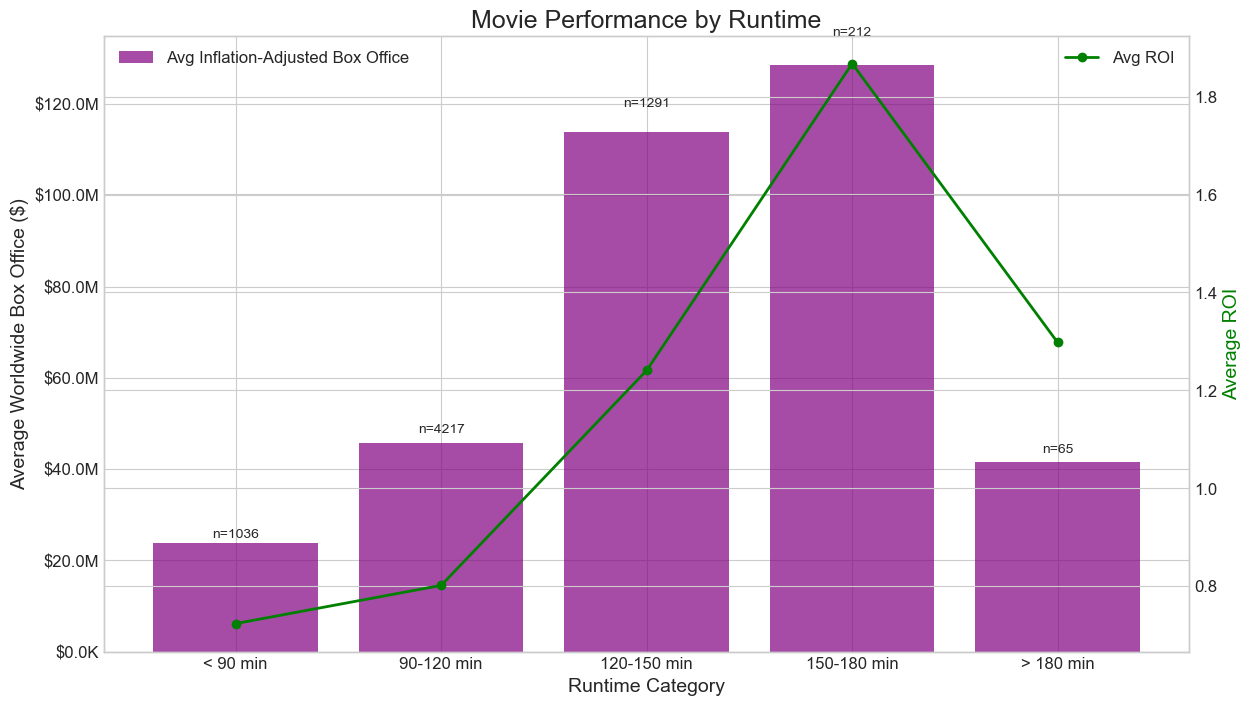

In [22]:
plt.figure(figsize=(14, 8))
runtime_bins = [0, 90, 120, 150, 180, 300]
runtime_labels = ['< 90 min', '90-120 min', '120-150 min', '150-180 min', '> 180 min']
df['runtime_category_detail'] = pd.cut(df['runtime'], bins=runtime_bins, labels=runtime_labels)

# Update aggregation to use inflation-adjusted values
runtime_perf = df.groupby('runtime_category_detail').agg({
    'inflation_adjusted_budget': 'median',
    'inflation_adjusted_worldwide_boxoffice': 'median',
    'roi': 'median',
    'final_title': 'count'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Plot inflation-adjusted worldwide box office as bars.
ax1.bar(runtime_perf['runtime_category_detail'], runtime_perf['inflation_adjusted_worldwide_boxoffice'], 
        color='purple', alpha=0.7, label='Avg Inflation-Adjusted Box Office')
# Plot ROI as a continuous green line.
ax2.plot(runtime_perf['runtime_category_detail'], runtime_perf['roi'], 
         'go-', linewidth=2, label='Avg ROI')

ax1.set_xlabel('Runtime Category', fontsize=14)
ax1.set_ylabel('Average Worldwide Box Office ($)', fontsize=14)
ax2.set_ylabel('Average ROI', fontsize=14, color='g')
ax1.yaxis.set_major_formatter(money_formatter)
plt.title('Movie Performance by Runtime', fontsize=18)

# Add movie count annotations above the bars
for i, (cat, count) in enumerate(zip(runtime_perf['runtime_category_detail'], runtime_perf['final_title'])):
    ax1.text(i, runtime_perf['inflation_adjusted_worldwide_boxoffice'].iloc[i] * 1.05, 
             f"n={count}", ha='center', fontsize=10)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

visualizations['runtime_impact'] = plt


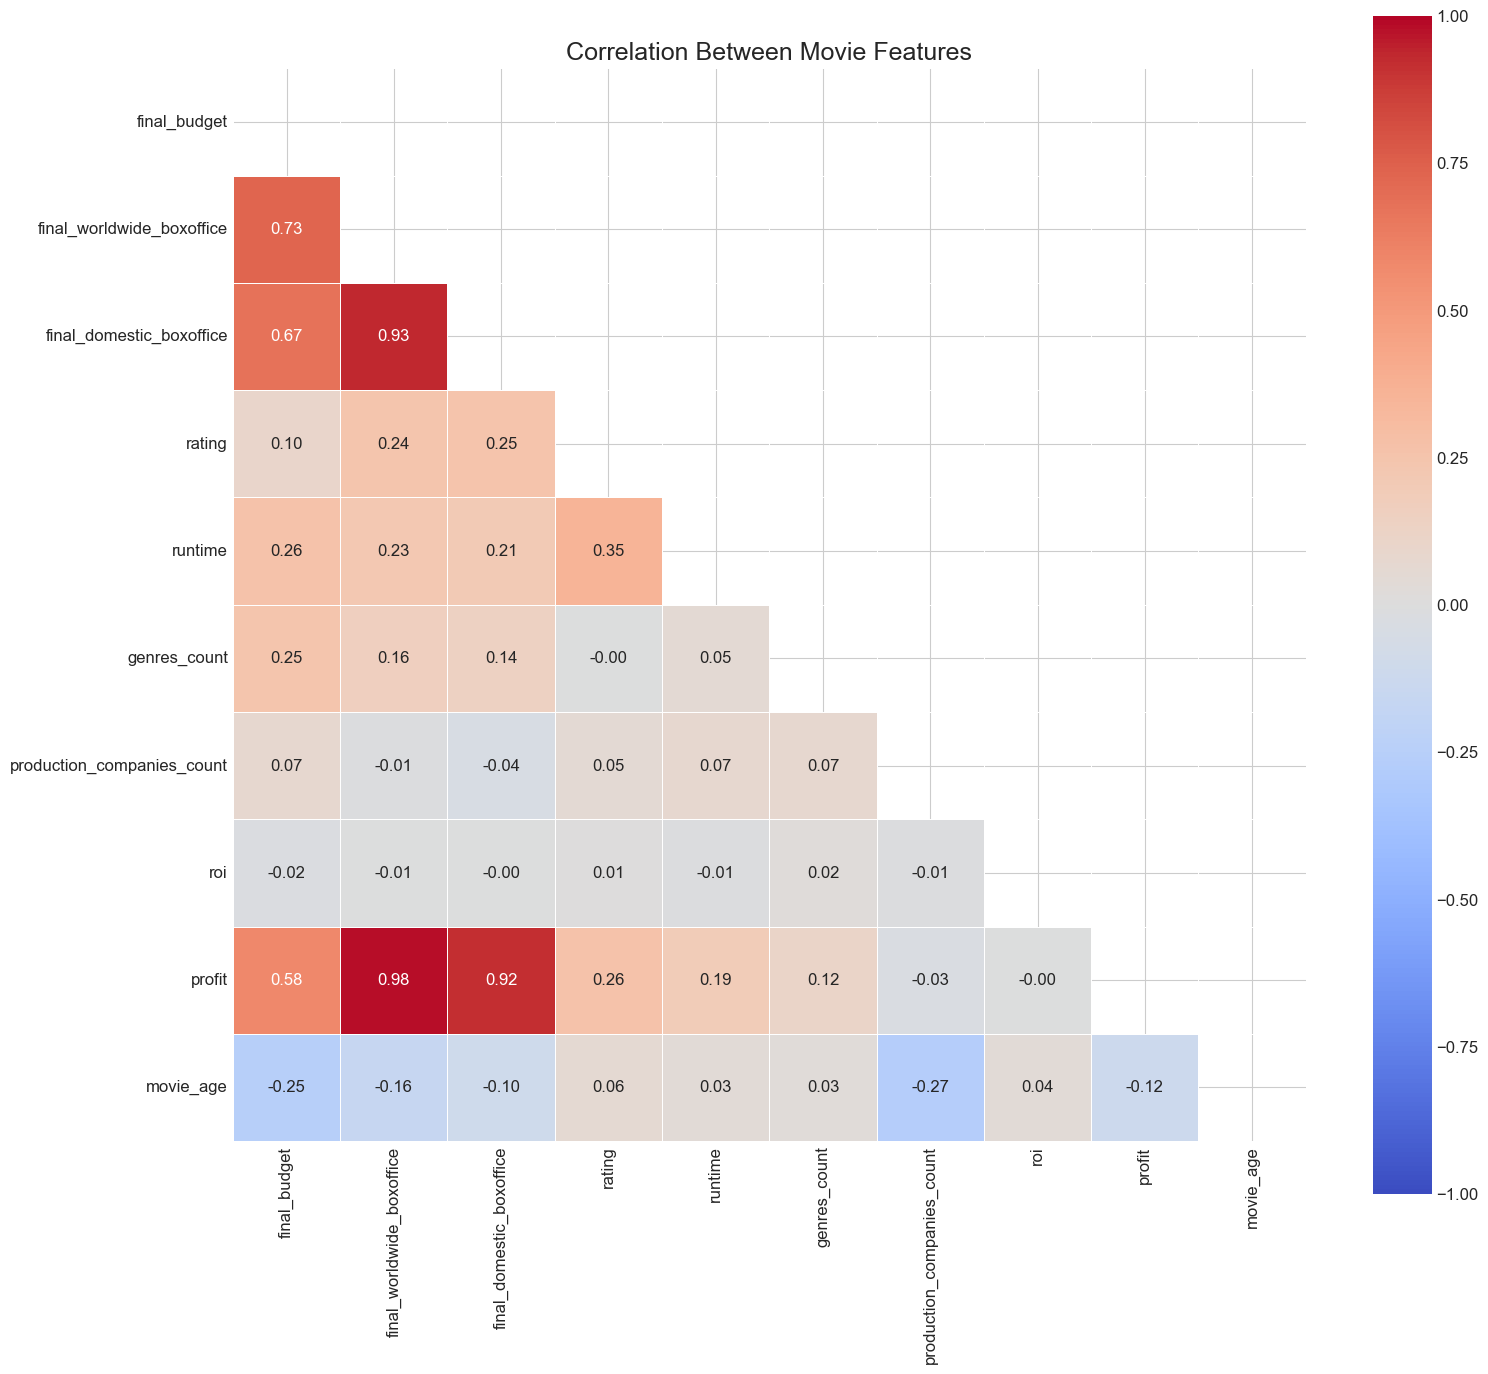

In [18]:
plt.figure(figsize=(16, 14))
numeric_cols = ['final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice', 
                'rating', 'runtime', 'genres_count', 'production_companies_count',
                'roi', 'profit', 'movie_age']
corr = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f')
plt.title('Correlation Between Movie Features', fontsize=18)
plt.tight_layout()

visualizations['correlation_heatmap'] = plt

C:\Users\divya\AppData\Local\Temp\ipykernel_28972\2375967742.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_budget = df.groupby('budget_quartile')['financial_success'].value_counts(normalize=True).unstack()


<Figure size 1400x800 with 0 Axes>

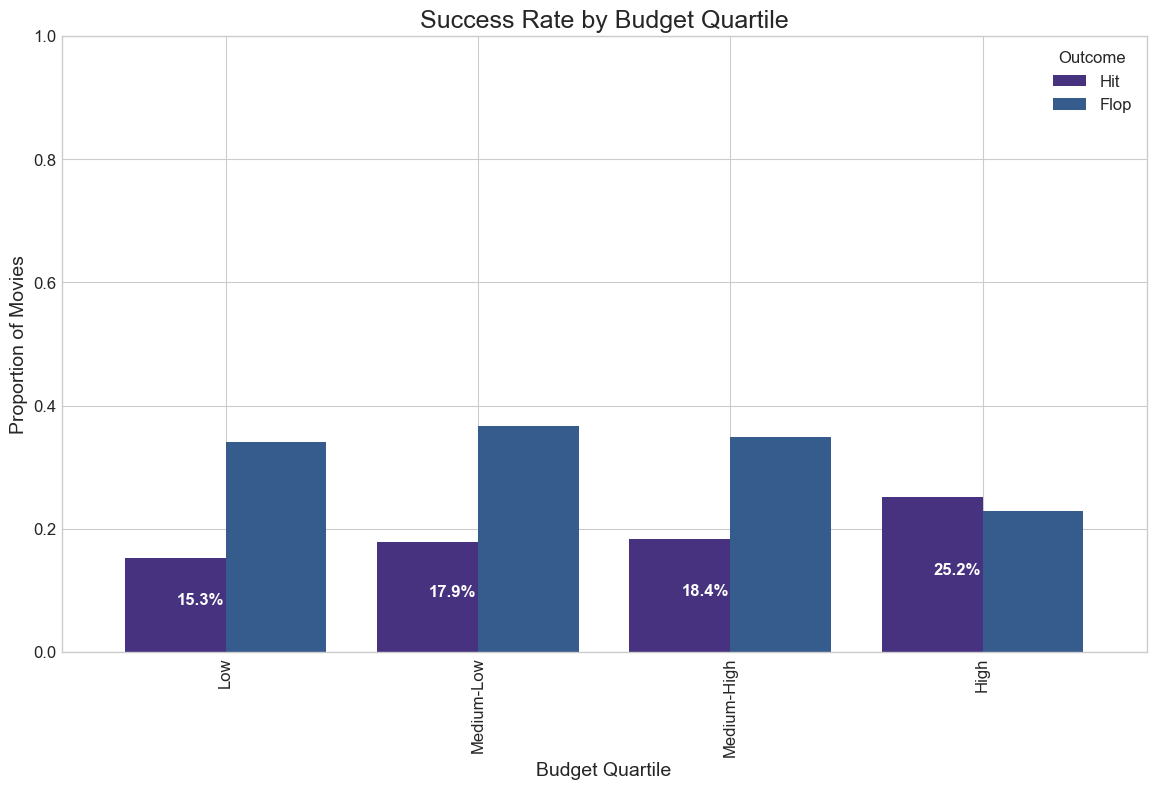

In [23]:
plt.figure(figsize=(14, 8))
df['budget_quartile'] = pd.qcut(df['final_budget'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
success_by_budget = df.groupby('budget_quartile')['financial_success'].value_counts(normalize=True).unstack()
success_by_budget = success_by_budget.reindex(['Low', 'Medium-Low', 'Medium-High', 'High'])

if 'Hit' in success_by_budget.columns and 'Flop' in success_by_budget.columns:
    ax = success_by_budget[['Hit', 'Flop']].plot(kind='bar', figsize=(14, 8), width=0.8)
    plt.title('Success Rate by Budget Quartile', fontsize=18)
    plt.xlabel('Budget Quartile', fontsize=14)
    plt.ylabel('Proportion of Movies', fontsize=14)
    plt.ylim(0, 1)
    
    # Add percentage annotations
    for i, v in enumerate(success_by_budget['Hit']):
        ax.text(i-0.1, v/2, f"{v:.1%}", color='white', fontweight='bold', ha='center')
    
    for i, v in enumerate(success_by_budget['Flop']):
        if 'Flop' in success_by_budget.columns:
            ax.text(i+0.1, 1-v/2, f"{v:.1%}", color='white', fontweight='bold', ha='center')
    
    plt.legend(title='Outcome')
    
    visualizations['success_by_budget'] = plt

<Figure size 1600x1000 with 0 Axes>

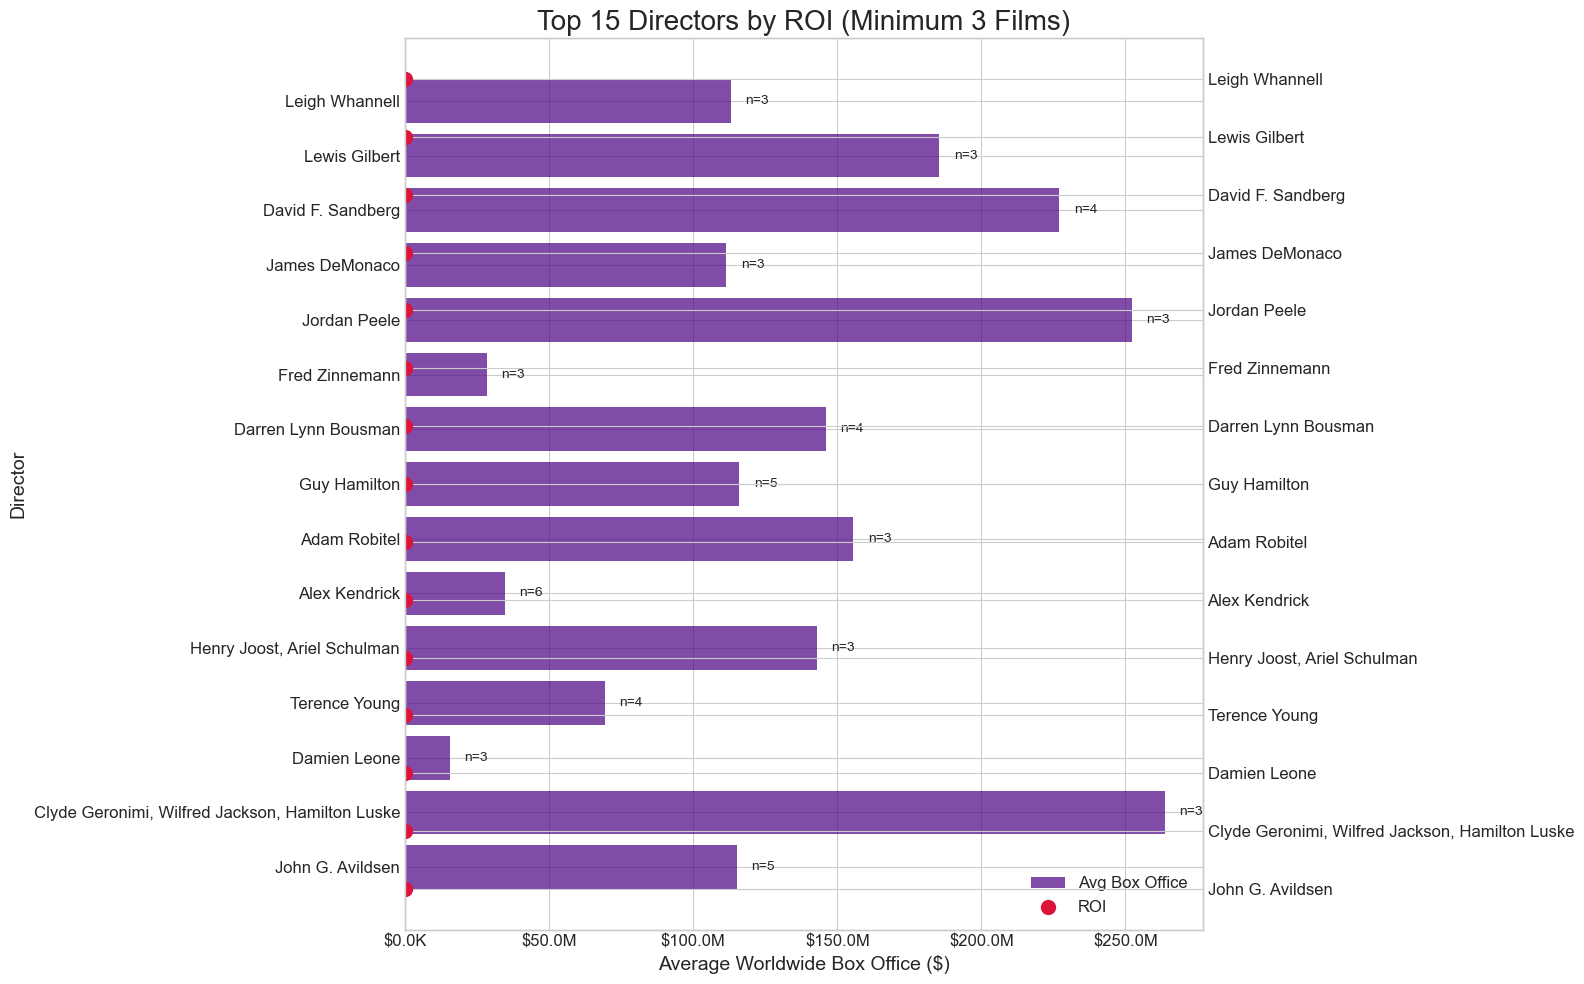

In [24]:
plt.figure(figsize=(16, 10))

# Get directors with at least 3 movies in the dataset for meaningful analysis
director_counts = df['director'].value_counts()
directors_with_multiple_films = director_counts[director_counts >= 3].index.tolist()

if directors_with_multiple_films:
    director_performance = df[df['director'].isin(directors_with_multiple_films)].groupby('director').agg({
        'final_budget': 'median',
        'final_worldwide_boxoffice': 'median',
        'roi': 'median',
        'final_title': 'count'
    }).reset_index()
    
    # Sort by ROI for identifying most profitable directors
    director_performance = director_performance.sort_values('roi', ascending=False).head(15)
    
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    
    bars = ax1.barh(director_performance['director'], director_performance['final_worldwide_boxoffice'], 
            color='indigo', alpha=0.7, label='Avg Box Office')
    line = ax2.scatter(director_performance['roi'], director_performance['director'], 
             color='crimson', s=100, label='ROI')
    
    ax1.set_xlabel('Average Worldwide Box Office ($)', fontsize=14)
    ax1.set_ylabel('Director', fontsize=14)
    ax2.set_xlabel('Return on Investment (ROI)', fontsize=14)
    ax1.xaxis.set_major_formatter(money_formatter)
    plt.title('Top 15 Directors by ROI (Minimum 3 Films)', fontsize=20)
    
    # Add movie count annotations
    for i, count in enumerate(director_performance['final_title']):
        ax1.text(director_performance['final_worldwide_boxoffice'].iloc[i] + 5e6, i, 
                 f"n={count}", va='center', fontsize=10)
    
    # Create a combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='lower right')
    
    plt.tight_layout()
    visualizations['top_directors'] = plt

<Figure size 1600x1000 with 0 Axes>

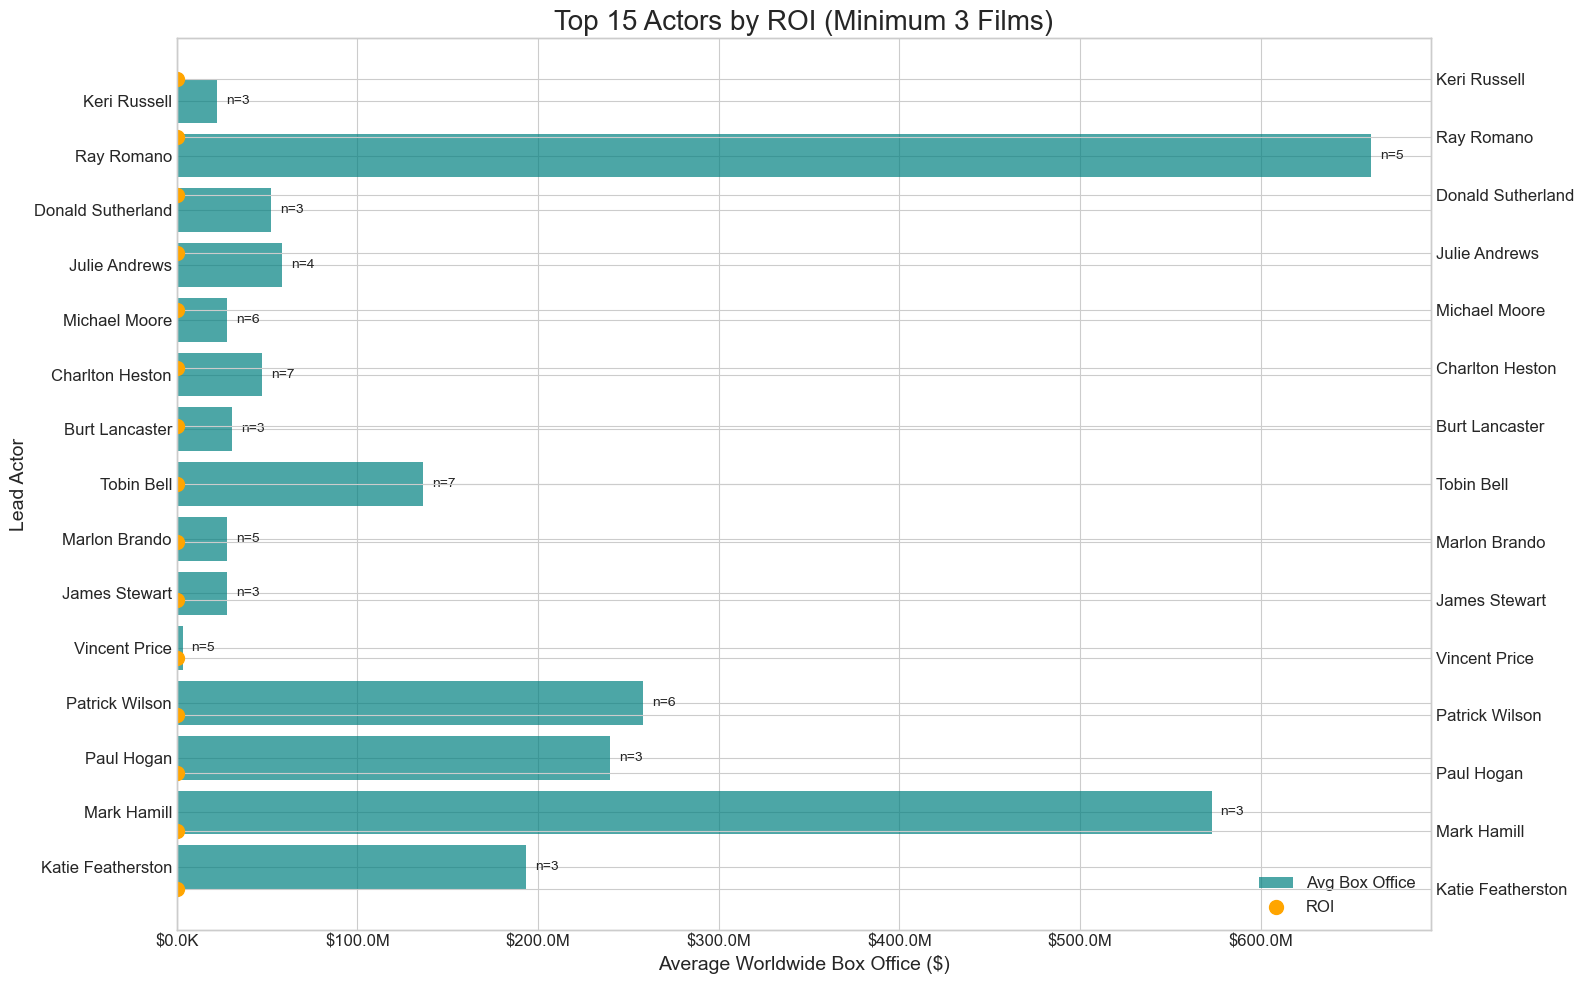

In [25]:
plt.figure(figsize=(16, 10))

# Process the star column to extract lead actors (assuming comma-separated list)
df['lead_actor'] = df['star'].str.split(',').str[0].str.strip()

# Get actors with at least 3 movies in the dataset
actor_counts = df['lead_actor'].value_counts()
actors_with_multiple_films = actor_counts[actor_counts >= 3].index.tolist()

if actors_with_multiple_films:
    actor_performance = df[df['lead_actor'].isin(actors_with_multiple_films)].groupby('lead_actor').agg({
        'final_budget': 'median',
        'final_worldwide_boxoffice': 'median',
        'roi': 'median',
        'final_title': 'count'
    }).reset_index()
    
    # Sort by ROI
    actor_performance = actor_performance.sort_values('roi', ascending=False).head(15)
    
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    
    bars = ax1.barh(actor_performance['lead_actor'], actor_performance['final_worldwide_boxoffice'], 
            color='teal', alpha=0.7, label='Avg Box Office')
    line = ax2.scatter(actor_performance['roi'], actor_performance['lead_actor'], 
             color='orange', s=100, label='ROI')
    
    ax1.set_xlabel('Average Worldwide Box Office ($)', fontsize=14)
    ax1.set_ylabel('Lead Actor', fontsize=14)
    ax2.set_xlabel('Return on Investment (ROI)', fontsize=14)
    ax1.xaxis.set_major_formatter(money_formatter)
    plt.title('Top 15 Actors by ROI (Minimum 3 Films)', fontsize=20)
    
    # Add movie count annotations
    for i, count in enumerate(actor_performance['final_title']):
        ax1.text(actor_performance['final_worldwide_boxoffice'].iloc[i] + 5e6, i, 
                 f"n={count}", va='center', fontsize=10)
    
    # Create a combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='lower right')
    
    plt.tight_layout()
    visualizations['top_actors'] = plt

<Figure size 1600x1000 with 0 Axes>

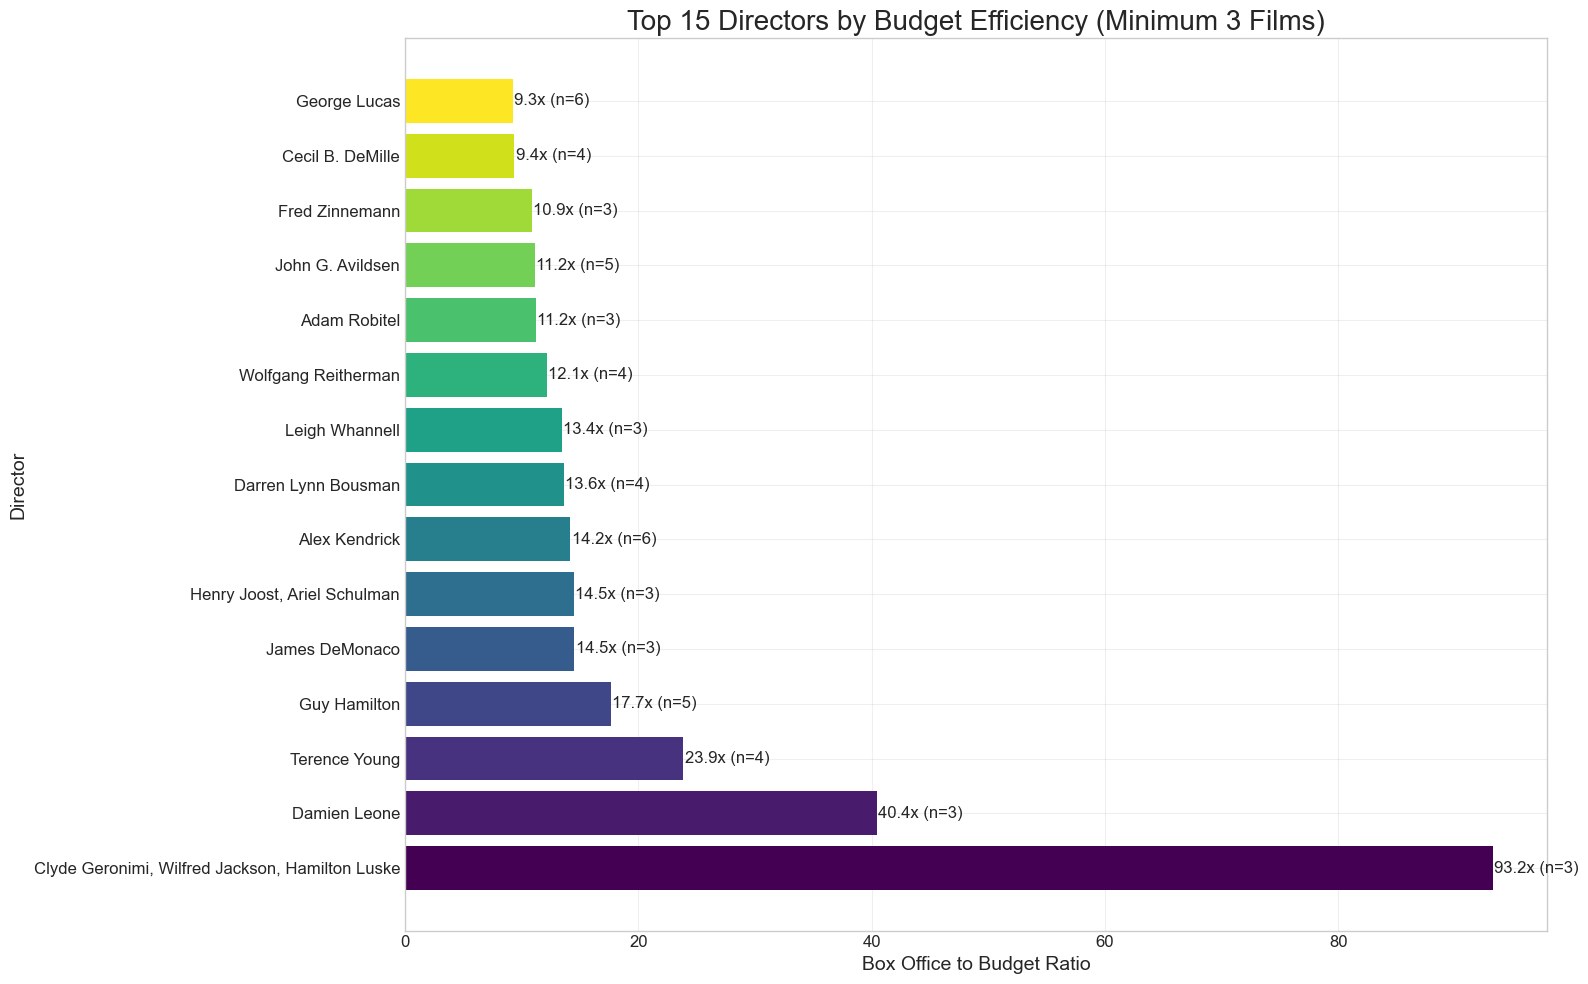

In [26]:
plt.figure(figsize=(16, 10))

if directors_with_multiple_films:
    # Calculate budget efficiency (box office divided by budget)
    director_efficiency = df[df['director'].isin(directors_with_multiple_films)].groupby('director').agg({
        'final_budget': 'mean',
        'final_worldwide_boxoffice': 'mean',
        'final_title': 'count'
    }).reset_index()
    
    director_efficiency['efficiency_ratio'] = director_efficiency['final_worldwide_boxoffice'] / director_efficiency['final_budget']
    director_efficiency = director_efficiency.sort_values('efficiency_ratio', ascending=False).head(15)
    
    plt.figure(figsize=(16, 10))
    bars = plt.barh(director_efficiency['director'], director_efficiency['efficiency_ratio'], 
            color=plt.cm.viridis(np.linspace(0, 1, len(director_efficiency))))
    
    plt.xlabel('Box Office to Budget Ratio', fontsize=14)
    plt.ylabel('Director', fontsize=14)
    plt.title('Top 15 Directors by Budget Efficiency (Minimum 3 Films)', fontsize=20)
    
    # Add annotations
    for i, (ratio, count) in enumerate(zip(director_efficiency['efficiency_ratio'], director_efficiency['final_title'])):
        plt.text(ratio + 0.1, i, f"{ratio:.1f}x (n={count})", va='center', fontsize=12)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    visualizations['director_efficiency'] = plt

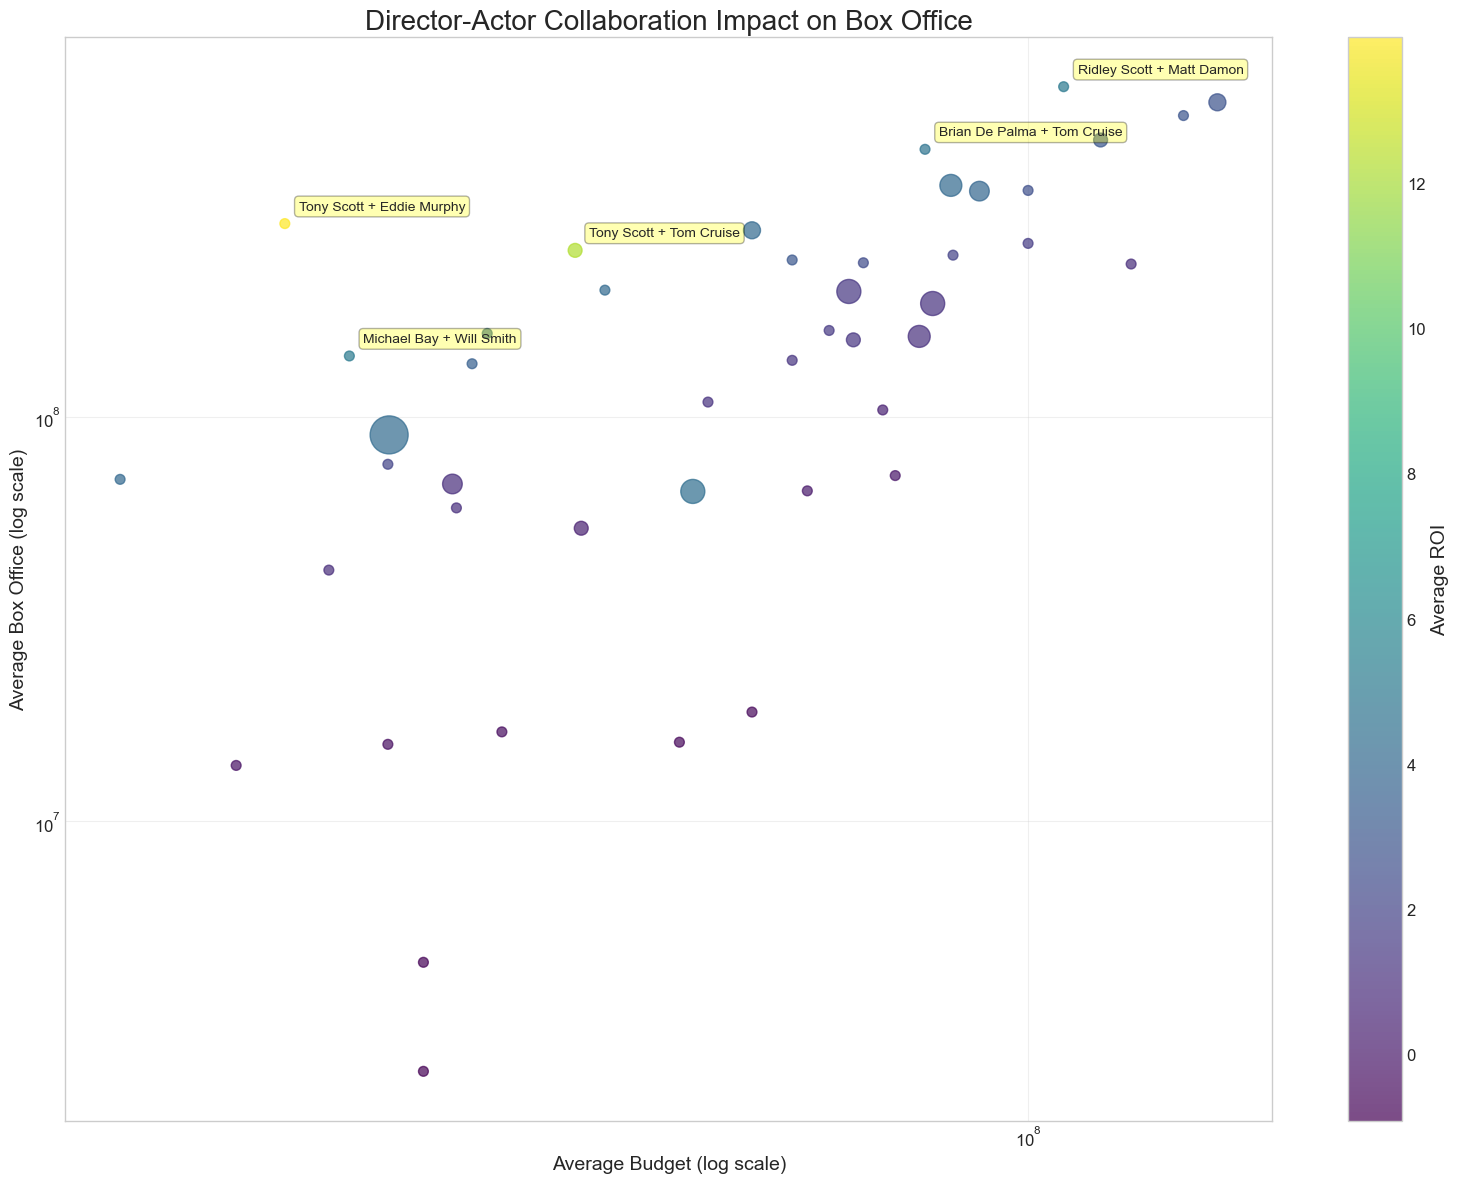

In [27]:
top_directors = director_counts[director_counts >= 3].index.tolist()[:20]
top_actors = actor_counts[actor_counts >= 3].index.tolist()[:20]

# Create a DataFrame for combinations that exist in the dataset
director_actor_impact = []

for director in top_directors:
    for actor in top_actors:
        combo_movies = df[(df['director'] == director) & (df['lead_actor'] == actor)]
        if len(combo_movies) > 0:
            avg_budget = combo_movies['final_budget'].mean()
            avg_boxoffice = combo_movies['final_worldwide_boxoffice'].mean()
            avg_roi = combo_movies['roi'].mean()
            movie_count = len(combo_movies)
            
            director_actor_impact.append({
                'director': director,
                'lead_actor': actor,
                'avg_budget': avg_budget,
                'avg_boxoffice': avg_boxoffice,
                'avg_roi': avg_roi,
                'movie_count': movie_count
            })

director_actor_df = pd.DataFrame(director_actor_impact)

if not director_actor_df.empty and len(director_actor_df) >= 5:  # Ensure we have enough data points
    # Create an interactive bubble chart
    fig = px.scatter(
        director_actor_df,
        x='avg_budget',
        y='avg_boxoffice',
        size='movie_count',
        color='avg_roi',
        hover_name='director',
        text='lead_actor',
        log_x=True,
        log_y=True,
        size_max=50,
        color_continuous_scale='Viridis'
    )
    
    fig.update_layout(
        title='Director-Actor Collaboration Impact on Box Office Performance',
        xaxis_title='Average Budget (log scale)',
        yaxis_title='Average Box Office (log scale)',
        font=dict(size=14),
        height=800,
        width=1200
    )
    
    # Save to HTML
    fig.write_html("director_actor_impact.html")
    
    # Create a static version for the report as well
    plt.figure(figsize=(16, 12))
    
    # Use a scatter plot with color mapping to ROI and size mapping to movie count
    scatter = plt.scatter(
        director_actor_df['avg_budget'], 
        director_actor_df['avg_boxoffice'],
        s=director_actor_df['movie_count'] * 50,  # Scale for visibility
        c=director_actor_df['avg_roi'],
        cmap='viridis',
        alpha=0.7
    )
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Average Budget (log scale)', fontsize=14)
    plt.ylabel('Average Box Office (log scale)', fontsize=14)
    plt.title('Director-Actor Collaboration Impact on Box Office', fontsize=20)
    
    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average ROI', fontsize=14)
    
    # Add annotations for notable points
    top_combos = director_actor_df.sort_values('avg_roi', ascending=False).head(5)
    for _, row in top_combos.iterrows():
        plt.annotate(
            f"{row['director']} + {row['lead_actor']}",
            (row['avg_budget'], row['avg_boxoffice']),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3)
        )
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    visualizations['director_actor_static'] = plt

<Figure size 1600x1000 with 0 Axes>

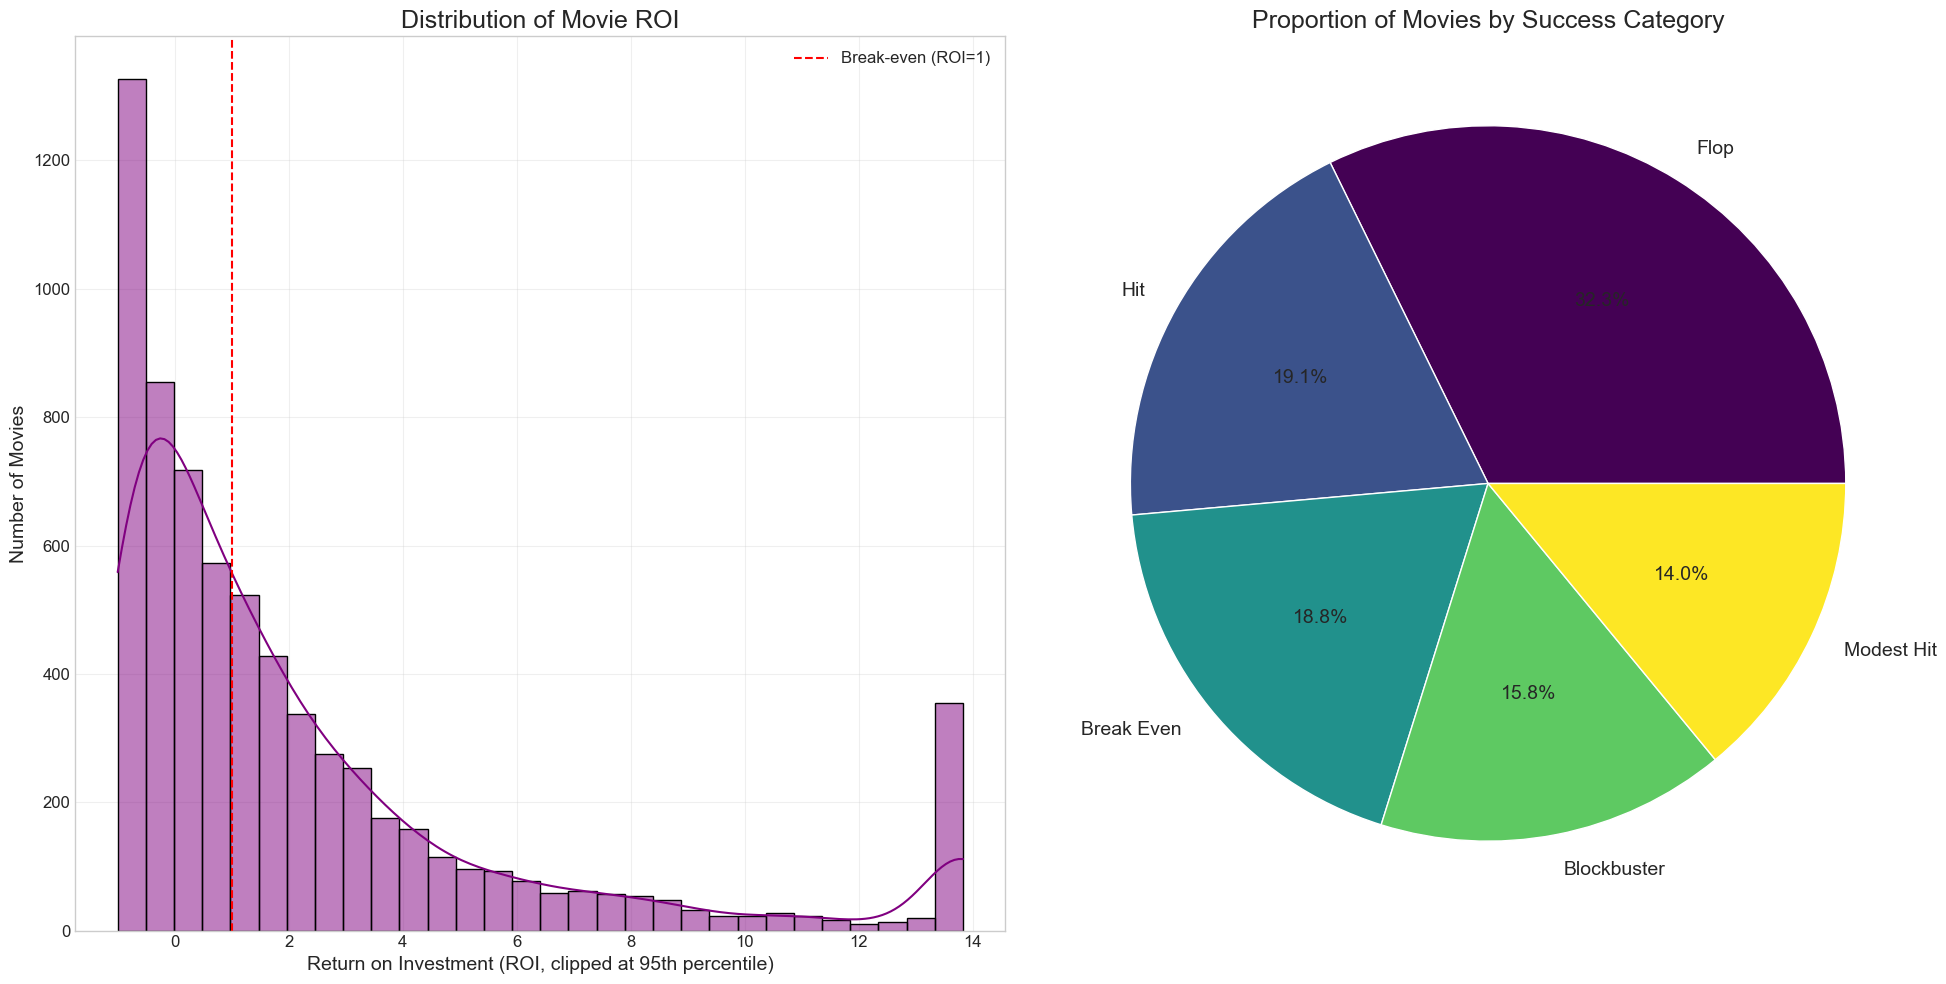

In [30]:
plt.figure(figsize=(16, 10))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# ROI Distribution (left subplot)
# Use clipping to handle extreme outliers while preserving distribution shape
roi_data = df['roi'].clip(upper=df['roi'].quantile(0.95))  # Clip at 95th percentile to handle outliers

sns.histplot(roi_data, bins=30, kde=True, ax=ax1, color='purple')
ax1.axvline(x=1, color='red', linestyle='--', label='Break-even (ROI=1)')
ax1.set_xlabel('Return on Investment (ROI, clipped at 95th percentile)', fontsize=14)
ax1.set_ylabel('Number of Movies', fontsize=14)
ax1.set_title('Distribution of Movie ROI', fontsize=18)
ax1.grid(True, alpha=0.3)
ax1.legend()

success_counts = df['financial_success'].value_counts()
ax2.pie(success_counts, labels=success_counts.index, autopct='%1.1f%%', 
        colors=plt.cm.viridis(np.linspace(0, 1, len(success_counts))),
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}, 
        textprops={'fontsize': 14})
ax2.set_title('Proportion of Movies by Success Category', fontsize=18)

plt.tight_layout()
visualizations['roi_success_distribution'] = plt

<Figure size 1600x1200 with 0 Axes>

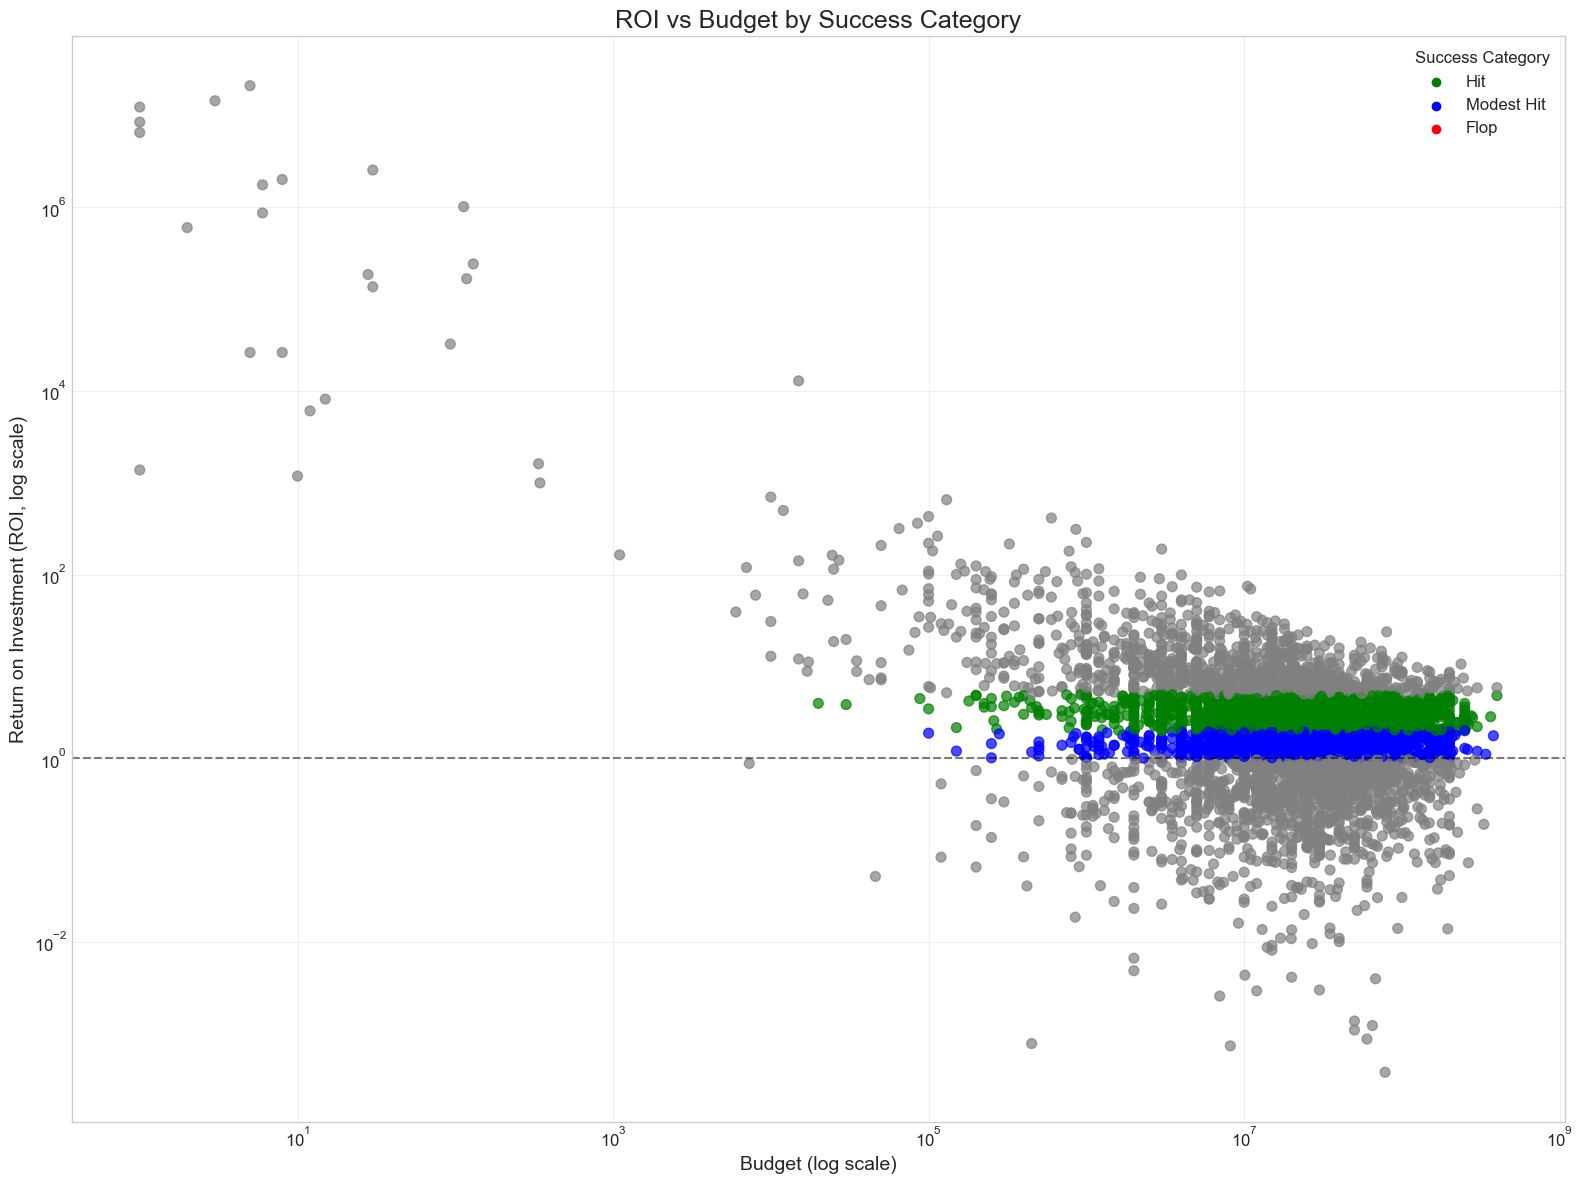

In [32]:
plt.figure(figsize=(16, 12))

# Create a scatter plot of ROI vs Budget colored by success category
plt.figure(figsize=(16, 12))

# Create a categorical color map
category_colors = {'Hit': 'green', 'Modest Hit': 'blue', 'Break-even': 'purple', 
                   'Disappointment': 'orange', 'Flop': 'red'}
                   
# Use available categories in the dataset
available_categories = df['financial_success'].unique()
colors = [category_colors.get(cat, 'gray') for cat in df['financial_success']]

# Create scatter plot
plt.scatter(df['final_budget'], df['roi'], 
            c=colors, alpha=0.7, s=50)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Budget (log scale)', fontsize=14)
plt.ylabel('Return on Investment (ROI, log scale)', fontsize=14)
plt.title('ROI vs Budget by Success Category', fontsize=18)
plt.grid(True, alpha=0.3)

# Create legend based on available categories
for cat in available_categories:
    if cat in category_colors:
        plt.scatter([], [], c=category_colors[cat], label=cat)
plt.legend(fontsize=12, title='Success Category')

# Add a horizontal line at ROI = 1 (break-even)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Break-even')

plt.tight_layout()
visualizations['roi_vs_budget_by_category'] = plt

C:\Users\divya\AppData\Local\Temp\ipykernel_4168\3707211881.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1800x1200 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

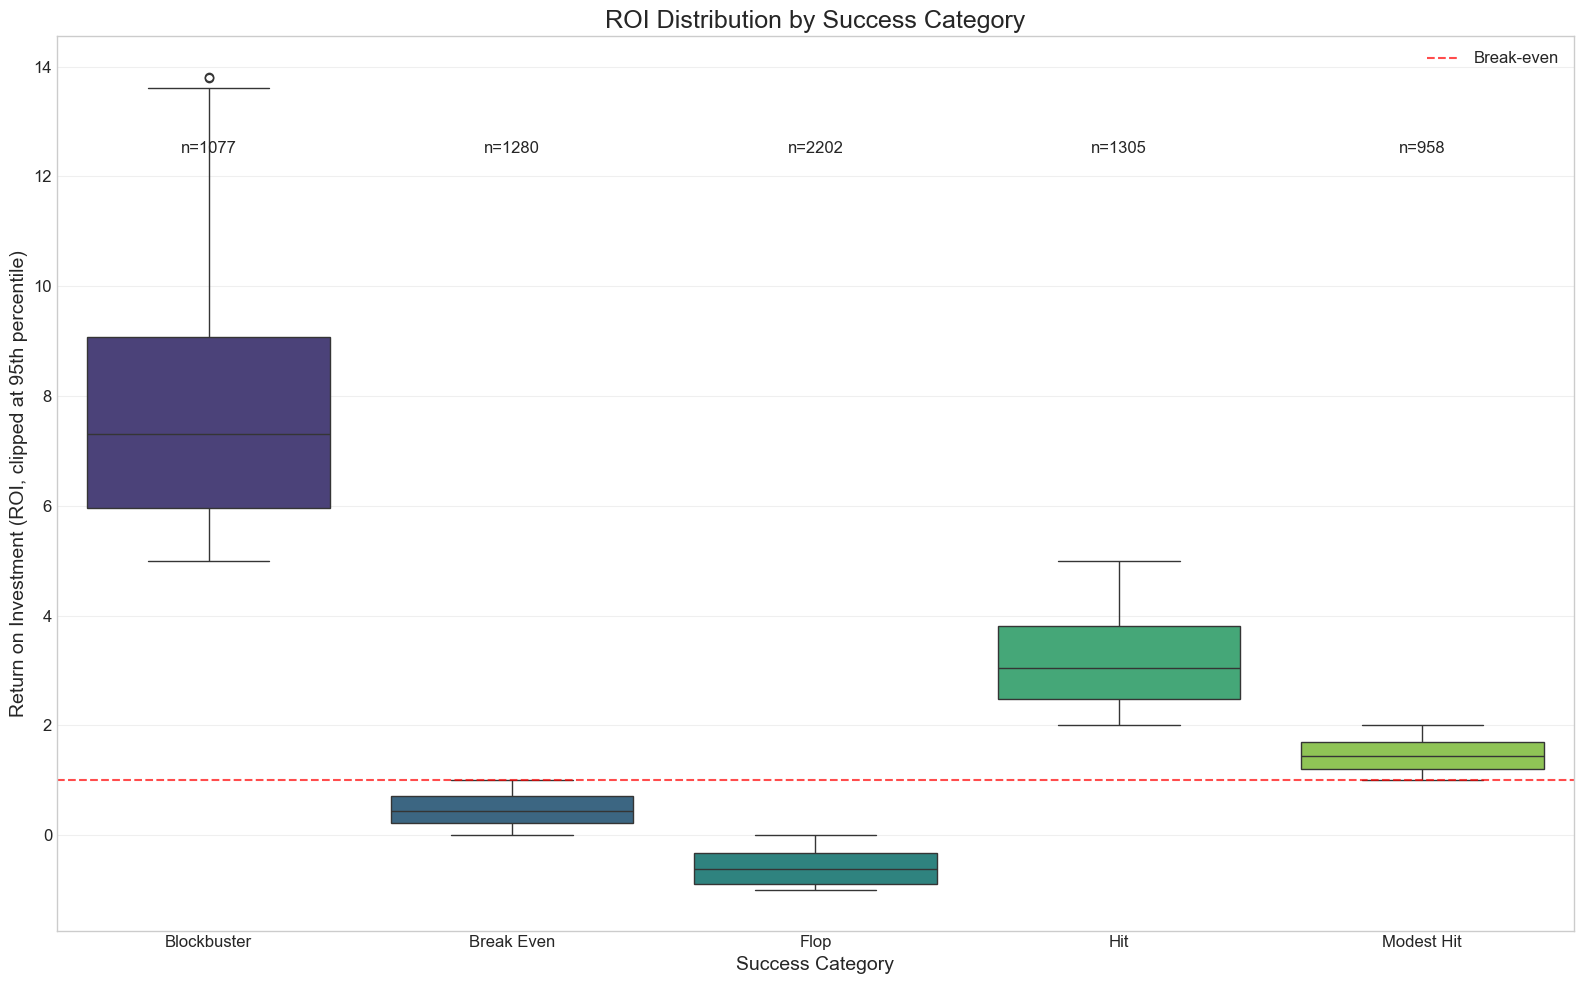

<Figure size 1800x1200 with 0 Axes>

In [34]:
plt.figure(figsize=(16, 10))

# Create a box plot of ROI by success category
plt.figure(figsize=(16, 10))

# Sort the categories in logical order if they follow a standard pattern
if all(cat in df['financial_success'].unique() for cat in ['Flop', 'Disappointment', 'Break-even', 'Modest Hit', 'Hit']):
    category_order = ['Flop', 'Disappointment', 'Break-even', 'Modest Hit', 'Hit']
    # Filter to only include categories present in the data
    category_order = [cat for cat in category_order if cat in df['financial_success'].unique()]
else:
    category_order = sorted(df['financial_success'].unique())

# Create box plot with limited ROI range to focus on the central distribution
ax = sns.boxplot(x='financial_success', y='roi', data=df[df['roi'] <= df['roi'].quantile(0.95)], 
                order=category_order, palette='viridis')

plt.xlabel('Success Category', fontsize=14)
plt.ylabel('Return on Investment (ROI, clipped at 95th percentile)', fontsize=14)
plt.title('ROI Distribution by Success Category', fontsize=18)
plt.grid(True, alpha=0.3, axis='y')

# Add a horizontal line at ROI = 1 (break-even)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Break-even')
plt.legend()

# Add category counts
for i, category in enumerate(category_order):
    count = len(df[df['financial_success'] == category])
    plt.text(i, df[df['roi'] <= df['roi'].quantile(0.95)]['roi'].max() * 0.9, 
             f"n={count}", ha='center', fontsize=12)

plt.tight_layout()
visualizations['roi_boxplot_by_category'] = plt

# 6. High ROI Movies Analysis (Top Performers)
plt.figure(figsize=(18, 12))

In [38]:
if 'plotly.express' in sys.modules:  # Check if plotly is available
    # Prepare data for sunburst chart
    success_data = []
    
    # Get genre breakdowns within each success category
    for success_cat in df['financial_success'].unique():
        success_movies = df[df['financial_success'] == success_cat]
        for genre in top_genres:
            genre_col = f'is_{genre.lower()}'
            if genre_col in df.columns:
                genre_count = success_movies[genre_col].sum()
                if genre_count > 0:
                    # Add budget subcategories
                    for budget_cat in ['Low', 'Medium-Low', 'Medium-High', 'High']:
                        budget_genre_count = success_movies[
                            (success_movies[genre_col] == 1) & 
                            (success_movies['budget_quartile'] == budget_cat)
                        ].shape[0]
                        
                        if budget_genre_count > 0:
                            success_data.append({
                                'Success': success_cat,
                                'Genre': genre,
                                'Budget': budget_cat,
                                'Count': budget_genre_count
                            })
    
    if success_data:
        success_df = pd.DataFrame(success_data)
        
        # Create path array for sunburst
        success_df['path'] = success_df['Success'] + "/" + success_df['Genre'] + "/" + success_df['Budget']
        
        # Create sunburst chart
        fig = px.sunburst(
            success_df, 
            path=['Success', 'Genre', 'Budget'],
            values='Count',
            color='Success',
            color_discrete_sequence=px.colors.qualitative.Vivid,
            title='Movie Success Categories Breakdown by Genre and Budget'
        )
        
        fig.update_layout(
            font=dict(size=14),
            height=800,
            width=1000
        )
        
        # Save to HTML
        fig.write_html("success_sunburst.html")

NameError: name 'sys' is not defined

<Figure size 1600x1000 with 0 Axes>

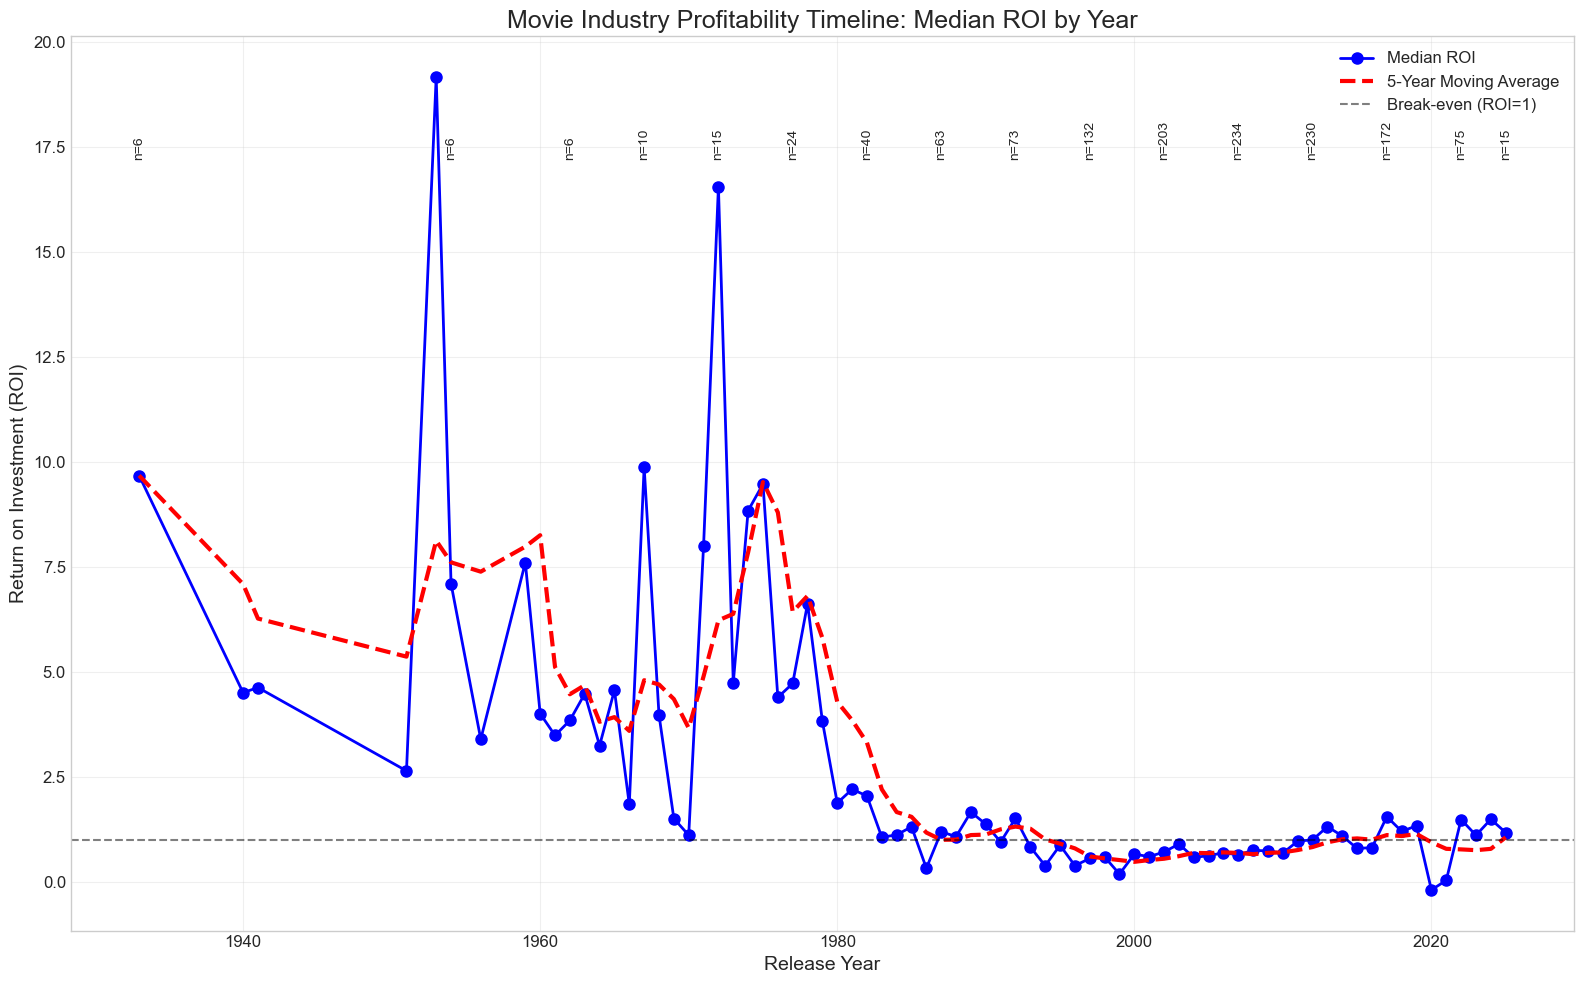

In [39]:
plt.figure(figsize=(16, 10))

# Calculate yearly average ROI
yearly_roi = df.groupby('final_year')['roi'].agg(['mean', 'median', 'count']).reset_index()
yearly_roi = yearly_roi[yearly_roi['count'] >= 5]  # Only include years with sufficient data

if len(yearly_roi) > 5:  # Only create visualization if we have enough years
    plt.figure(figsize=(16, 10))
    
    # Plot the median ROI (more robust to outliers)
    plt.plot(yearly_roi['final_year'], yearly_roi['median'], 'o-', 
             color='blue', linewidth=2, markersize=8, label='Median ROI')
    
    # Add a 5-year moving average
    yearly_roi['rolling_median'] = yearly_roi['median'].rolling(window=5, min_periods=1).mean()
    plt.plot(yearly_roi['final_year'], yearly_roi['rolling_median'], '--', 
             color='red', linewidth=3, label='5-Year Moving Average')
    
    # Add a horizontal line at ROI = 1 (break-even)
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Break-even (ROI=1)')
    
    plt.xlabel('Release Year', fontsize=14)
    plt.ylabel('Return on Investment (ROI)', fontsize=14)
    plt.title('Movie Industry Profitability Timeline: Median ROI by Year', fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add count annotations for context
    for i, (year, count) in enumerate(zip(yearly_roi['final_year'], yearly_roi['count'])):
        # Add counts every 5 years for readability
        if i % 5 == 0 or i == len(yearly_roi) - 1:
            plt.text(year, yearly_roi['median'].max() * 0.9, f"n={count}", 
                     ha='center', rotation=90, fontsize=10)
    
    plt.tight_layout()
    visualizations['roi_timeline'] = plt